<a href="https://colab.research.google.com/github/KentaLange/ICSI435HW2/blob/main/ICSI435_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!ls -l /content/ANN.py
!pwd
!ls -l /content/ColabTest/mlhw2/ANN_LeNet_MNIST_demo.py
! curl -O http://yann.lecun.com/exdb/mnist/
#!python gdrive/My\ Drive/Colab\ Notebooks/object_detection_demo-master/test.py
#download_mnist()
#save_mnist()


-rw-r--r-- 1 root root 1663 Oct 11 01:44 /content/ANN.py
/content
ls: cannot access '/content/ColabTest/mlhw2/ANN_LeNet_MNIST_demo.py': No such file or directory
curl: Remote file name has no length!
curl: (23) Failed writing received data to disk/application


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns
import socket
import sys
import argparse
import pickle
import random
import numpy as np
#import skimage.io as io
import matplotlib.pyplot as plt
from pprint import pprint

sys.path.append("../ColabTest/mlhw2")

import MNIST_util
import nn_layer
import ANN
import CNN
import activation
import pooling
import nn_layer
import conv_layer

import loss
import optimizer

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, utils

In [22]:

from ANN import TwoLayerNet
class ThreeLayerNet ():
  def __init__(self, D_in, H1, H2, D_out, weights=''):
    #The H2 in  __init__ function is the output dimension of the second FC layer and the input dimension of the third FC layer.

    self.FC1 = nn_layer.FC (D_in, H1)#28*28
    self.ReLU1 = activation.ReLU()
    self.FC2 = nn_layer.FC (H1, H2)
    self.ReLU2 = activation.ReLU()
    self.FC3 = nn_layer.FC(H2, D_out)#10*10
    if weights == '':
      pass
    else:
      # Load weights from file
      with open (weights,'rb') as f:
        params = pickle.load(f)
        self.set_params(params)


  def forward (self, X):
    h1 = self.FC1._forward(X)
    a1 = self.ReLU1._forward(h1)
    h2 = self.FC2._forward(a1)
    a2 = self.ReLU2._forward(h2)
    h3 = self.FC3._forward(a2)
    return h3

  def backward (self, dout):
    dout = self.FC3._backward(dout)
    dout = self.ReLU2._backward(dout)
    dout = self.FC2._backward(dout)
    dout = self.ReLU1._backward(dout)
    dout = self.FC1._backward(dout)



  def get_params(self):
    return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b,self.FC3.W,self.FC3.b]


  def set_params(self, params):
    [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b,self.FC3.W,self.FC3.b] = params



In [25]:


# ========== Net Trainer - Begin ==========

def get_batch (X, Y, batch_size):
# randomly select batch_size data samples
  N = len(X)
  i = random.randint(1, N-batch_size)
  return X[i:i+batch_size], Y[i:i+batch_size]

def MakeOneHot (Y, D_out):
  N = Y.shape[0]
  Z = np.zeros((N, D_out))
  Z[np.arange(N), Y] = 1
  return Z

class MNIST_Trainer ():
  def __init__(self, X_train, Y_train, Net='LeNet5', opti='SGDMomentum'):
    # Prepare Data: Load, Shuffle, Normalization, Batching, Preprocessing
    self.X_train = X_train
    self.Y_train = Y_train

    self.batch_size = 64
    # D_in: input depth of network, 784, 28*28 input grayscale image
    self.D_in = 784
    # D_out: output depth of network = 10, the 10 digits
    self.D_out = 10

    print ('  Net: ' + str(Net))
    print ('  batch_size: ' + str(self.batch_size))
    print ('  D_in: ' + str(self.D_in))
    print ('  D_out: ' + str(self.D_out))
    print ('  Optimizer: ' + opti)

    # =======================
    if Net == 'TwoLayerNet':
      # H is the size of the one hidden layer.
      H=400
      self.model = ANN.TwoLayerNet (self.D_in, H, self.D_out)
    elif Net == 'ThreeLayerNet':
    #######################################
    ############  TODO   ##################
    #######################################
      # H1, H2 are the size of the two hidden layers.
      #The H2 in  __init__ function is the output dimension of the second FC layer and the input dimension of the third FC layer.
      H1=300
      H2=100
      self.model = ThreeLayerNet (self.D_in, H1, H2, self.D_out)

    elif Net == 'LeNet5':
      self.model = CNN.LeNet5 ()

    # store training loss over iterations, for later visualization
    self.losses = []

    if opti == 'SGD':
      self.opti = optimizer.SGD (self.model.get_params(), lr=0.0001, reg=0)
    else:
      self.opti = optimizer.SGDMomentum (self.model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)

    self.criterion = loss.CrossEntropyLoss ()


  def Train (self, Iter = None):
    if not Iter:
      Iter = 25000

    for i in range(Iter):
      # get batch, make onehot
      X_batch, Y_batch = get_batch (self.X_train, self.Y_train, self.batch_size)
      Y_batch = MakeOneHot (Y_batch, self.D_out)

      # forward, loss, backward, step
      Y_pred = self.model.forward (X_batch)
      loss, dout = self.criterion.get (Y_pred, Y_batch)
      self.model.backward (dout)
      self.opti.step()

      if i % 100 == 0:
        print ('Iter %d (%.2f%%), loss = %f' % (i, 100.0*i/Iter, loss))
        self.losses.append (loss)

      #if i==0:
      #  viz_batch (X_batch, i)

    return self.model

# ========== Net Trainer - End ==========

# ========== Evaluation - Begin ==========

def determine_Train_Acc (model, X_train, Y_train):
  Y_pred = model.forward (X_train)
  result = np.argmax (Y_pred, axis=1) - Y_train
  result = list (result)

  n_correct = result.count(0)
  n_total = X_train.shape[0]
  Acc = float(n_correct) / n_total
  print ('TRAIN--> Correct: %d out of %d. Acc=%f' \
    % (n_correct, n_total, Acc))
  return Acc

def determine_Test_Acc (model, X_test, Y_test):
  Y_pred = model.forward (X_test)
  result = np.argmax (Y_pred, axis=1) - Y_test
  result = list (result)

  n_correct = result.count(0)
  n_total = X_test.shape[0]
  Acc = float(n_correct) / n_total
  print ('TEST--> Correct: %d out of %d. Acc=%f' \
    % (n_correct, n_total, Acc))
  return Acc

# ========== Evaluation - End ==========





In [45]:
#if __name__ == '__main__':
 # parser = argparse.ArgumentParser()
  #parser.add_argument('-model', dest='model', default='TwoLayerNet', choices=['TwoLayerNet', 'ThreeLayerNet', 'LeNet5'], help="Select the NeuralNet model")
  #parser.add_argument('-iter', dest='iter', default=25000, type=int, help="Training iterations")
  #parser.add_argument('-opti', dest='opti', default='SGDMomentum', choices=['SGDMomentum', 'SGD'], help="Select optimizer")
  #args = parser.parse_args()

X_train, Y_train, X_test, Y_test = MNIST_util.MNIST_preparation ('../ColabTest/mlhw2/')
Y_enc_train = MakeOneHot (Y_train, 10)
Y_enc_test = MakeOneHot (Y_test, 10)
print(f"Initial  data shape: {X_train.shape} and {Y_train.shape}, {X_test.shape} and {Y_test.shape}, 1H {Y_enc_train.shape} and {Y_enc_test.shape} ")

model = None
X_val = X_train[-2000:,:,]
Y_val = Y_enc_train[-2000:]

print(f'Initial Val Shape: {X_val.shape} and {Y_val.shape}')

X_train_data = X_train[:-2000,:,]
Y_train_data = Y_enc_train[:-2000]

def mainLoop (model_name,iteration,optimizer):
  #Since I am not using terminal to run this, I made this as a method.
  #X_train, Y_train, X_test, Y_test = MNIST_util.MNIST_preparation ()

  # Net: TwoLayerNet, ThreeLayerNet, LeNet5
    if model_name == 'LeNet5':
        model = LeNet(iter,opti)
        model.name = "LeNet5"
    elif model_name == 'TwoLayerNet':
        model = TwoLayerNet(iter,optimizer)
        model.name = "TwoLayerNet"
    elif model_name == 'ThreeLayerNet':
        model = ThreeLayerNet(iter,optimizer)
        model.name = "ThreeLayerNet"
    print(model.summary())
    #optim: SGD, SGDMomentum
    #opti = optimizer
    #trainer = MNIST_Trainer (X_train, Y_train, Net, opti)

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss=losses.categorical_crossentropy, metrics=['accuracy'])
    elif optimizer == 'SGDMomentum':
        model.compile(optimizer=tf.keras.optimizers.SGD(momentum=.8, learning_rate=0.0001), loss=losses.categorical_crossentropy, metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam, loss=losses.categorical_crossentropy, metrics=['accuracy'])

  #For 25000 iter TwoLayerNet, we should get train Acc 0.937983, test Acc 0.938700
  #For 25000 iter ThreeLayerNet, we should get train Acc 0.953133, test Acc 0.952500
  #For 1000 iter LeNet5, we should get test Acc 0.1135
  #Iter = iteration
  #model = trainer.Train (Iter)

    history = model.fit(X_train_data, Y_train_data, batch_size=64, epochs=iteration, validation_data=(X_val, Y_val)  )
    # weights = model.get_params()
    # with open ('~weights.pkl','wb') as f:
    #   pickle.dump (weights, f)

    #genGraph(history['loss'], model_name)
    model.evaluate(X_test,Y_enc_test)
    return history,model

  


  # save params

  #######################################
  ############  TODO   ##################
  #######################################

  # plot training l
  #y=training loss-self.losses from trainer.losses
  #x=iteration number

#  determine_Train_Acc (model, X_train, Y_train)
#  determine_Test_Acc (model, X_test, Y_test)
#  return trainer,model


X_train mean: 0.130660, X_test mean: 0.132515
Initial  data shape: (60000, 784) and (60000,), (10000, 784) and (10000,), 1H (60000, 10) and (10000, 10) 
Initial Val Shape: (2000, 784) and (2000, 10)


In [ ]:
def LeNet(iter:int=0,opti:str=''):
    # img_shape = (1, 28, 28)
    # X_train = X_train.reshape(-1, *img_shape)
    # X_test = X_test.reshape(-1, *img_shape)
    # Pad two to the right, two down from 0... 
    ## Commented out /255 as this is done elsewhere normalize values to 1 (I guess)

    
    model = models.Sequential()
    model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=X_train.shape[1:]))
    model.add(layers.AveragePooling2D(2))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Conv2D(16, 5, activation='tanh'))
    model.add(layers.AveragePooling2D(2))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Conv2D(120, 5, activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(84, activation='tanh'))
    model.add(layers.Dense(10, activation='softmax'))
    return model


def TwoLayerNet(iter:int=0,opti:str=''):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(784,)))
#    model.add(layers.Flatten(input_shape=(0,784)))
    model.add(layers.Dense(400, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

def ThreeLayerNet(iter:int=0,opti:str=''):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(784,)))
 #   model.add(layers.Flatten(input_shape=(784)))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [ ]:
#Takes losses and title of the graph. X-axis represents the number of iteration/100. Y-axis represents the losses.
def genGraph(losses,title=''):
  plt.figure()
  plt.plot(losses)
  plt.title(f'{title}: losses vs iteration')
  plt.xlabel("Iterations")
  plt.ylabel("Losses")

  plt.show()

In [ ]:
#part (a):For 25000 iter TwoLayerNet, we should get train Acc 0.937983, test Acc 0.938700
history,model=mainLoop(model_name='TwoLayerNet',iteration=250,optimizer='SGD')


In [ ]:
genGraph(history.history['loss'], 'TwoLayerNet')


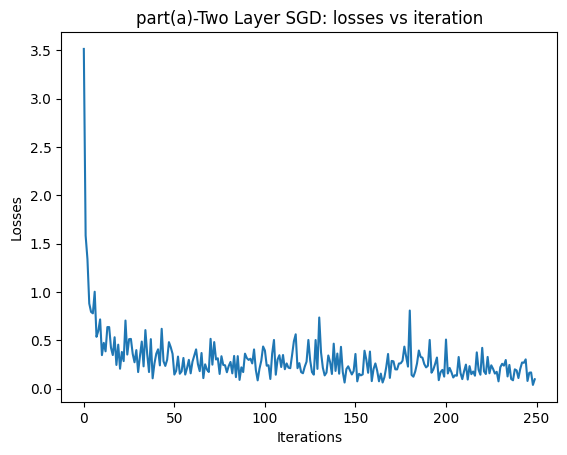

In [21]:
genGraph(trainer.losses,'part(a)-Two Layer SGD')


In [ ]:
model=mainLoop(model_name='TwoLayerNet',iteration=250,optimizer='SGDMomentum')

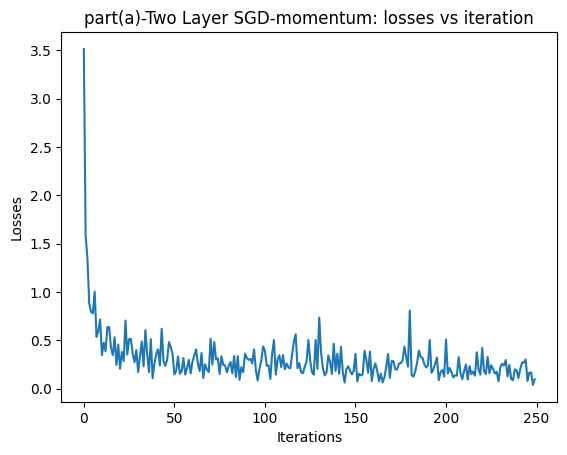

In [22]:
genGraph(trainer.losses,'part(a)-Two Layer SGD-momentum')

In [9]:
#part (b):ThreeLayerNet by yourself. Set H1=300, H2=100, and train the ThreeLayerNet model 25000 iterations.
trainer,model=mainLoop(model='ThreeLayerNet',iteration=25000,optimizer='SGD')

X_train mean: 0.130660, X_test mean: 0.132515
  Net: ThreeLayerNet
  batch_size: 64
  D_in: 784
  D_out: 10
  Optimizer: SGD
Iter 0 (0.00%), loss = 3.318933
Iter 100 (0.40%), loss = 1.634781
Iter 200 (0.80%), loss = 1.141210
Iter 300 (1.20%), loss = 0.959118
Iter 400 (1.60%), loss = 0.660272
Iter 500 (2.00%), loss = 0.820132
Iter 600 (2.40%), loss = 0.793542
Iter 700 (2.80%), loss = 0.632476
Iter 800 (3.20%), loss = 0.482832
Iter 900 (3.60%), loss = 0.562042
Iter 1000 (4.00%), loss = 0.252539
Iter 1100 (4.40%), loss = 0.406408
Iter 1200 (4.80%), loss = 0.537751
Iter 1300 (5.20%), loss = 0.383867
Iter 1400 (5.60%), loss = 0.399205
Iter 1500 (6.00%), loss = 0.267648
Iter 1600 (6.40%), loss = 0.363182
Iter 1700 (6.80%), loss = 0.383239
Iter 1800 (7.20%), loss = 0.553170
Iter 1900 (7.60%), loss = 0.303566
Iter 2000 (8.00%), loss = 0.184295
Iter 2100 (8.40%), loss = 0.347005
Iter 2200 (8.80%), loss = 0.651694
Iter 2300 (9.20%), loss = 0.338726
Iter 2400 (9.60%), loss = 0.235457
Iter 2500 (1

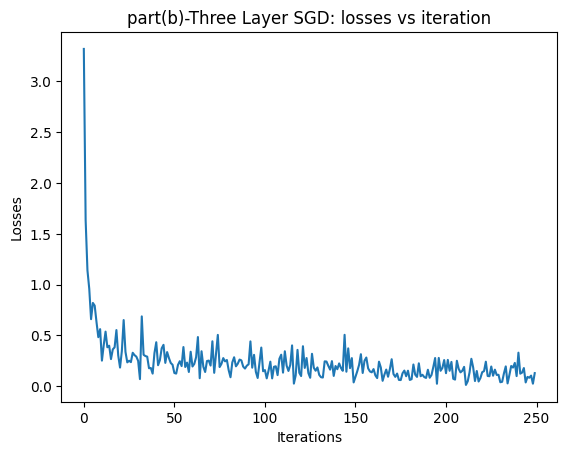

In [12]:
#part(b)
genGraph(trainer.losses,'part(b)-Three Layer SGD')

In [13]:
trainer,model=mainLoop(model='ThreeLayerNet',iteration=25000,optimizer='SGDMomentum')

X_train mean: 0.130660, X_test mean: 0.132515
  Net: ThreeLayerNet
  batch_size: 64
  D_in: 784
  D_out: 10
  Optimizer: SGDMomentum
Iter 0 (0.00%), loss = 4.438820
Iter 100 (0.40%), loss = 1.678685
Iter 200 (0.80%), loss = 1.219716
Iter 300 (1.20%), loss = 1.082589
Iter 400 (1.60%), loss = 0.647409
Iter 500 (2.00%), loss = 0.553638
Iter 600 (2.40%), loss = 0.580210
Iter 700 (2.80%), loss = 0.507565
Iter 800 (3.20%), loss = 0.439851
Iter 900 (3.60%), loss = 0.548791
Iter 1000 (4.00%), loss = 0.461483
Iter 1100 (4.40%), loss = 0.756431
Iter 1200 (4.80%), loss = 0.403169
Iter 1300 (5.20%), loss = 0.678740
Iter 1400 (5.60%), loss = 0.394946
Iter 1500 (6.00%), loss = 0.493215
Iter 1600 (6.40%), loss = 0.479143
Iter 1700 (6.80%), loss = 0.289664
Iter 1800 (7.20%), loss = 0.299145
Iter 1900 (7.60%), loss = 0.314026
Iter 2000 (8.00%), loss = 0.338581
Iter 2100 (8.40%), loss = 0.214125
Iter 2200 (8.80%), loss = 0.365420
Iter 2300 (9.20%), loss = 0.475917
Iter 2400 (9.60%), loss = 0.254980
Iter

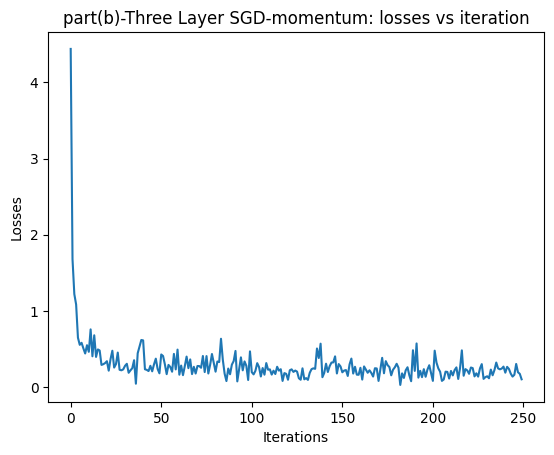

In [15]:
genGraph(trainer.losses,'part(b)-Three Layer SGD-momentum')

In [23]:
#part (c):Train LeNet5 model 2000 iterations, report the accuracy on testing dataset.
#LeNet5 takes more than one hour to run. Needs good hardware to run.
trainer,model=mainLoop(model='LeNet5',iteration=2000,optimizer='SGD')

X_train mean: 0.130660, X_test mean: 0.132515
  Net: LeNet5
  batch_size: 64
  D_in: 784
  D_out: 10
  Optimizer: SGD
Iter 0 (0.00%), loss = 2.286783
Iter 100 (5.00%), loss = 2.302746
Iter 200 (10.00%), loss = 2.318180
Iter 300 (15.00%), loss = 2.308301
Iter 400 (20.00%), loss = 2.313146
Iter 500 (25.00%), loss = 2.287832
Iter 600 (30.00%), loss = 2.289382
Iter 700 (35.00%), loss = 2.286026
Iter 800 (40.00%), loss = 2.315630
Iter 900 (45.00%), loss = 2.296311
Iter 1000 (50.00%), loss = 2.309254
Iter 1100 (55.00%), loss = 2.316627
Iter 1200 (60.00%), loss = 2.309702
Iter 1300 (65.00%), loss = 2.316853
Iter 1400 (70.00%), loss = 2.314577
Iter 1500 (75.00%), loss = 2.328563
Iter 1600 (80.00%), loss = 2.304146
Iter 1700 (85.00%), loss = 2.304374
Iter 1800 (90.00%), loss = 2.310382
Iter 1900 (95.00%), loss = 2.297602
TRAIN--> Correct: 5923 out of 60000. Acc=0.098717
TEST--> Correct: 980 out of 10000. Acc=0.098000


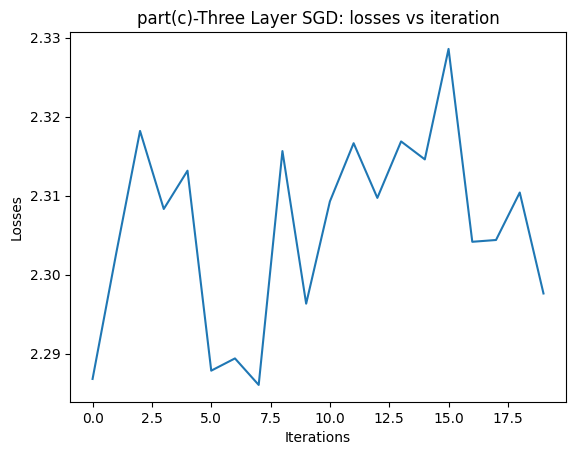

In [24]:
genGraph(trainer.losses,'part(c)-Three Layer SGD')

In [ ]:
#part(c): Session crashs after using all available RAM.
mainLoop(model='LeNet5',iteration=2000,optimizer='SGDMomentum')

X_train mean: 0.130660, X_test mean: 0.132515
  Net: LeNet5
  batch_size: 64
  D_in: 784
  D_out: 10
  Optimizer: SGDMomentum
Iter 0 (0.00%), loss = 2.317848
Iter 100 (5.00%), loss = 2.226775
Iter 200 (10.00%), loss = 2.371181
Iter 300 (15.00%), loss = 2.309516
Iter 400 (20.00%), loss = 2.313148


In [ ]:
genGraph(trainer.losses,'part(c)-Three Layer SGD-Momentum')

NameError: name 'genGraph' is not defined